In [1]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup as bs
import sqlite3
from datetime import date
from datetime import datetime as dt
import hashlib
import sys
import os
import locale
import re
import requests as rq
import wbdata as wb
from contextlib import contextmanager
import pytz
from datetime import timedelta
from currency_converter import CurrencyConverter

cc = CurrencyConverter()
from matplotlib import pyplot as plt
from sklearn import preprocessing as prep
import numpy as np
from technical_analysis import candles
from technical_analysis import overlays
from technical_analysis import indicators
from technical_analysis.backtest.strategy import (
    MovingAverageCrossover,
    CenterLineCrossover,
)
from technical_analysis.backtest.backtest import Backtest

import mplfinance as mpf

project_dir = "/home/mi/Dropbox/prog/python/tradeDB"
os.chdir(project_dir)

from importlib import reload

# from workers import sql
from workers import api

# from workers.common import read_json, hash_table
import tradeDB

In [2]:
pkn = tradeDB.Trader()
pkn.get(
    tab="stock", symbol="pkn", columns="-indexes;-industry;-info", start_date="1-1-2020"
)

In [4]:
req_cols = ["open", "high", "low", "val", "vol", "symbol", "date"]
df = (
    pkn.data.reindex(columns=req_cols)
    .drop_duplicates()
    .rename(columns={"val": "close", "vol": "volume"})
    .reset_index()
    .sort_values(by=["symbol", "date"])
)
df["date"] = pd.to_datetime(df["date"])
df.set_index("date", inplace=True) # for mpf plot only
df["ta"] = 0

In [7]:
# strategy
strategy = [
    {
        "columns_req": {
            "ema9": {"func": indicators.ema, "kwargs": {"period": 9}},
            "ema20": {"func": indicators.ema, "kwargs": {"period": 20}},
        },
        "entry": [MovingAverageCrossover("ema9", "ema20", "bullish")],
        "exit": [MovingAverageCrossover("ema9", "ema20", "bearish")],
    },
    {
        "columns_req": {
            "ema50": {"func": indicators.ema, "kwargs": {"period": 50}},
            "ema200": {"func": indicators.ema, "kwargs": {"period": 200}},
        },
        "entry": [MovingAverageCrossover("ema50", "ema200", "bullish")],
        "exit": [MovingAverageCrossover("ema50", "ema200", "bearish")],
    },
    {
        "columns_req": {
            "macd": {"func": indicators.macd, "kwargs": {"output": ["macd"]}},
            "macd_sig": {"func": indicators.macd, "kwargs": {"output": ["signal"]}},
        },
        "entry": [MovingAverageCrossover("macd", "macd_sig", "bullish")],
        "exit": [MovingAverageCrossover("macd", "macd_sig", "bearish")],
    },
    {
        "columns_req": {},
        "entry": [CenterLineCrossover("macd", "bullish")],
        "exit": [CenterLineCrossover("macd", "bearish")],
    },
]

for s in strategy:
    # prepare columns
    for col in s["columns_req"]:
        df[col] = s["columns_req"][col]["func"](df, **s["columns_req"][col]['kwargs'])
    
    test = Backtest(entry_criteria=s["entry"], exit_criteria=s["exit"])
    test.run(df)
    df['ta'] += test.signal()
    print(test.results)


df["ta"] = df["ta"].cumsum()

{'benchmark': -0.11815154592594791, 'strategy': 0.23784804791891442, 'max_drawdown': -0.15151445349198803, 'max_profit': 0.27921805636215086, 'avg_return': 0.01829600368607034, 'std_return': 0.10310910256630969, 'returns': [-0.03186279482861348, 0.13020972865398608, 0.27921805636215086, 0.06930163850084174, -0.0820732701379707, -0.011583899419706655, -0.03162488830969433, 0.03874270057244768, -0.02595441108935579, -0.15151445349198803, 0.0690432609384351, 0.03746153168353344, -0.05151515151515149]}
{'benchmark': -0.11815154592594791, 'strategy': 0.27853881729294605, 'max_drawdown': -0.010179179781874714, 'max_profit': 0.28871799707482076, 'avg_return': 0.13926940864647303, 'std_return': 0.14944858842834774, 'returns': [0.28871799707482076, -0.010179179781874714]}
{'benchmark': -0.11815154592594791, 'strategy': 0.5829754864534722, 'max_drawdown': -0.21193801569732332, 'max_profit': 0.3694049201533151, 'avg_return': 0.023319019458138888, 'std_return': 0.13074690404830488, 'returns': [-0.

In [8]:
df

,index,open,high,low,close,volume,symbol,ta,ema9,ema20,ema50,ema200,macd,macd_sig
date,,,,,,,,,,,,,,
2019-12-30,1952,70.7335,71.0788,70.1246,70.6017,526813,PKN,0,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-02,1950,71.1614,71.8029,70.5033,71.5393,783654,PKN,0,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-03,1948,71.1614,71.2757,69.7625,70.5191,886384,PKN,0,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-07,1946,70.6518,70.7335,67.5904,67.7064,1893473,PKN,0,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-08,1944,67.4762,67.9858,66.8830,67.0807,961300,PKN,0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-13,8,62.5700,62.9600,61.6600,61.8500,1568499,PKN,13,63.807342,63.923242,62.892561,60.873887,0.348463,0.978685
2023-11-14,6,62.0600,64.4400,62.0100,64.2700,2072087,PKN,12,63.899874,63.956266,62.946578,60.907679,0.342622,0.851473
2023-11-15,4,65.0000,65.2000,62.9600,63.2300,2376026,PKN,12,63.765899,63.887098,62.957692,60.930787,0.251178,0.731414


/home/mi/.backup/venv/tradeDB/lib64/python3.11/site-packages/mplfinance/_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


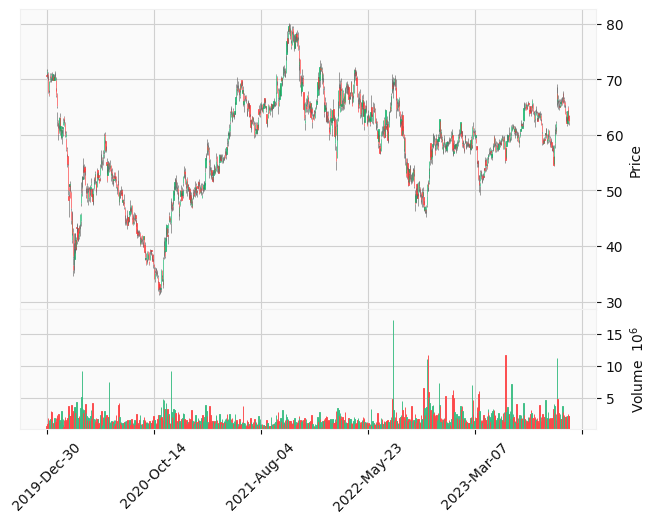

In [16]:
mpf.plot(
    df, type="candle", volume=True, show_nontrading=False, figsize=(8, 6), style="yahoo"
)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


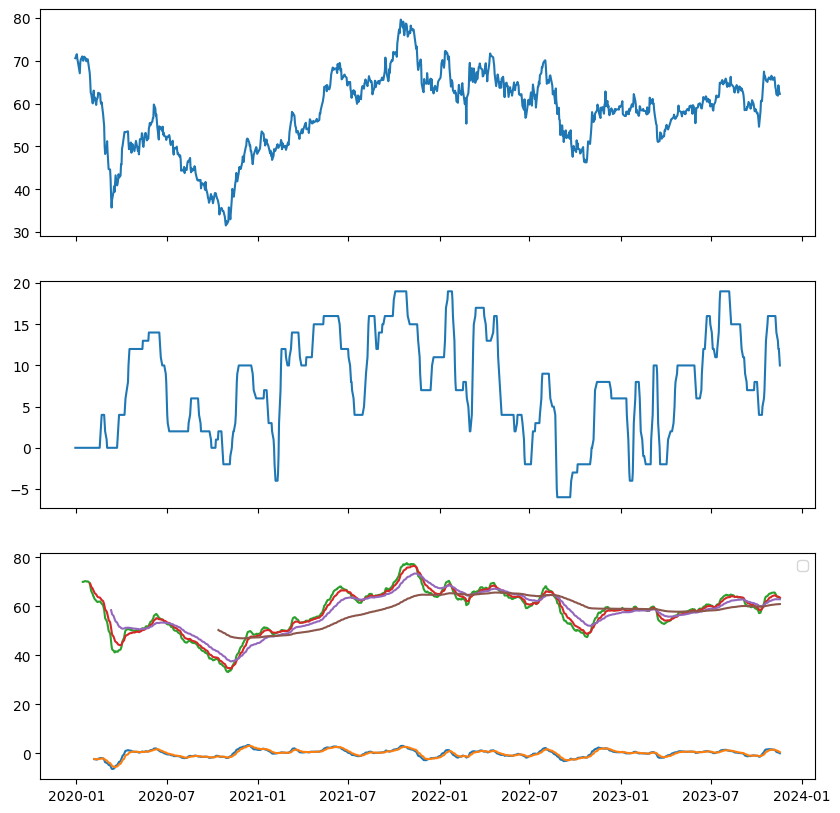

In [9]:
fig, axs = plt.subplots(3, 1, figsize=(10, 10), sharex=True)

axs[1].plot(df["ta"])
axs[2].plot(df["macd"])
axs[2].plot(df["macd_sig"])
axs[2].plot(df["ema9"])
axs[2].plot(df["ema20"])
axs[2].plot(df["ema50"])
axs[2].plot(df["ema200"])
axs[0].plot(df["close"])
axs[2].legend()

In [ ]:
# band indicators: stochastic, bolinger, mcad, rsi
# 1. centerline crossover
# 2. divergence
df["perc_k"], df["perc_d"] = indicators.stochastic(
    df["high"], df["low"], df["close"], 14, 3, 3
)